In [34]:
import matplotlib.pyplot as plt
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
cd ../..

c:\Users\janse\Documents\GitHub\ufc-match-predictor


In [3]:
from ufc import load_data, constants

In [4]:
# Load data
df = load_data.read_prepped_data()

In [5]:
# Define response and feaatures
response = "outcome"

features = [
    'weight_class',
    'delta_height', 'delta_age', 'delta_reach',
    'delta_sig_strikes_landed_pm', 'delta_sig_strikes_accuracy',
    'delta_sig_strikes_absorbed_pm', 'delta_sig_strikes_defended',
    'delta_takedown_avg_per15m', 'delta_takedown_accuracy',
    'delta_takedown_defence', 'delta_submission_avg_attempted_per15m'
]

In [10]:
# Encode outcome
le = LabelEncoder()
df['outcome'] = le.fit_transform(df['outcome'])

In [27]:
# One-hot encode categorical features
categorical_features = ['weight_class']
numeric_features = [col for col in features if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [11]:
# Split data
X = df[features]
y = df[response]

# Split the data into training, validation, and test sets - 70% / 15% / 15%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=constants.SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=constants.SEED
)


In [19]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Grid search for best hyperparameters
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['delta_height',
                                                                          'delta_age',
                                                                          'delta_reach',
                                                                          'delta_sig_strikes_landed_pm',
                                                                          'delta_sig_strikes_accuracy',
                                                                          'delta_sig_strikes_absorbed_pm',
                                                                          'delta_sig_strikes_defended',
                                                                          'delta_takedown_avg_per15m',
                                                                          'delta_takedown_accuracy',
                                                                          'delta_takedown_defen...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [20]:
# Best model
best_model = grid_search.best_estimator_

In [25]:
# Errors on validation set
y_val_pred = best_model.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("Confusion Matrix:\n", val_conf_matrix)
print("Classification Report:\n", val_class_report)

Accuracy: 0.6388308977035491
Confusion Matrix:
 [[149  87]
 [ 86 157]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63       236
           1       0.64      0.65      0.64       243

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479



In [26]:
# Errors on test set
y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", test_conf_matrix)
print("Classification Report:\n", test_class_report)

Accuracy: 0.6430062630480167
Confusion Matrix:
 [[152  95]
 [ 76 156]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.62      0.64       247
           1       0.62      0.67      0.65       232

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.64      0.64      0.64       479



In [32]:
one_hot_encoder.get_feature_names_out()

array(['weight_class_Bantamweight', 'weight_class_Catch Weight',
       'weight_class_Featherweight', 'weight_class_Flyweight',
       'weight_class_Heavyweight', 'weight_class_Light Heavyweight',
       'weight_class_Lightweight', 'weight_class_Middleweight',
       'weight_class_Welterweight', "weight_class_Women's Bantamweight",
       "weight_class_Women's Featherweight",
       "weight_class_Women's Flyweight",
       "weight_class_Women's Strawweight"], dtype=object)

                                  Feature  Importance
3             delta_sig_strikes_landed_pm    0.145001
4              delta_sig_strikes_accuracy    0.139546
5           delta_sig_strikes_absorbed_pm    0.112471
1                               delta_age    0.075763
11              weight_class_Bantamweight    0.070856
7               delta_takedown_avg_per15m    0.061771
18              weight_class_Middleweight    0.056268
6              delta_sig_strikes_defended    0.050002
8                 delta_takedown_accuracy    0.043916
15               weight_class_Heavyweight    0.039592
9                  delta_takedown_defence    0.039348
0                            delta_height    0.031977
10  delta_submission_avg_attempted_per15m    0.031660
23       weight_class_Women's Strawweight    0.030783
14                 weight_class_Flyweight    0.022833
12              weight_class_Catch Weight    0.019648
22         weight_class_Women's Flyweight    0.017743
2                           

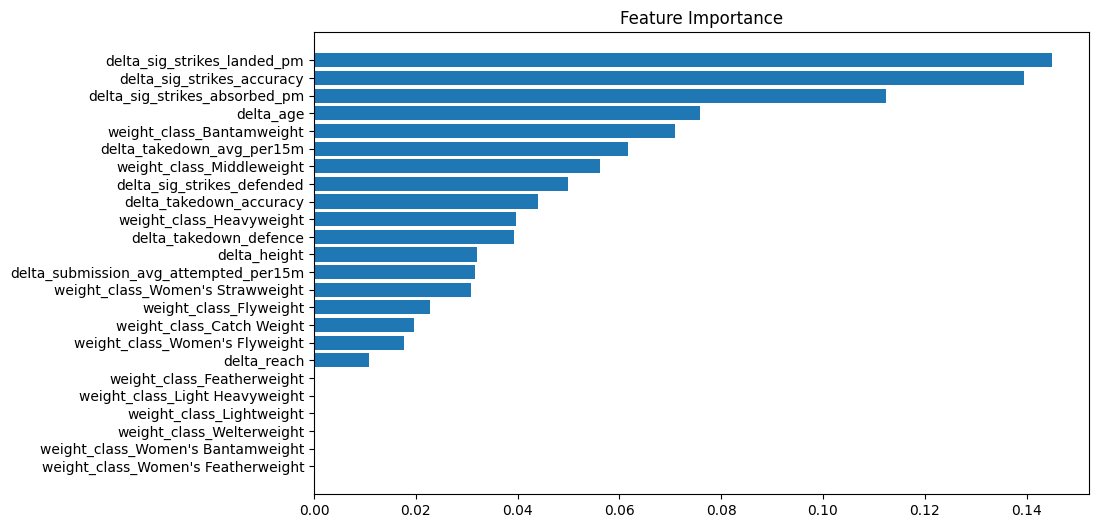

In [39]:
# Feature importance
feature_importances = best_model.named_steps['classifier'].feature_importances_

one_hot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
input_features = one_hot_encoder.get_feature_names_out()
feature_names = numeric_features + list(input_features)

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df\
    .sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], align='center')
plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()
